# Мобильные приложения — Выделение групп пользователей на основе поведения

# Основные цели данного прокта:
- **Проведение исследовательского анализа данных**
- **Сегментация пользователей на основе действий**
- **Проверка статистических гипотез**
- **Ответ на вопросы бизнеса:**
    1. Пользователи какой группы склонные часто возвращаться в мобильное приложение?
    2. Пользователи какой группы часто делают целевое событие?


### **Описание данных:**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет **mobile_dataset.csv** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

## Загрузка и предобработка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


In [2]:
# загрузим данные
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')

mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')


In [3]:
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
mobile_sourсes.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [5]:
# посмотрим, информация по скольким пользователям содержится в одном и другом датасетах
print(mobile_dataset['user.id'].nunique())
print(mobile_sourсes['userId'].nunique())

4293
4293


Количество одинаковое: имеем данные по 4293 пользователям

In [6]:
# объединим датасеты в один датафрейм
mobile_dataset = mobile_dataset.merge(mobile_sourсes, left_on='user.id', right_on='userId', right_index=False)
mobile_dataset.drop(columns='userId',inplace=True)

# изменим имена столбцам
mobile_dataset.columns = ['event_time', 'event', 'user_id', 'source']

In [7]:
mobile_dataset.head()

,event_time,event,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other


In [8]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event       74197 non-null  object
 2   user_id     74197 non-null  object
 3   source      74197 non-null  object
dtypes: object(4)
memory usage: 2.8+ MB


Имеем 74197 событий, четыре столбца с типами object. Пропусков в данных нет

In [9]:
# приведем столбец со временем события к datetime
mobile_dataset.event_time = pd.to_datetime(mobile_dataset.event_time)

In [10]:
# проверим наличие строк-дубликатов
mobile_dataset.duplicated().sum()

0

Дубликатов нет

In [11]:
# проверим уникальные значения в столбце с источником
mobile_dataset.source.unique()

array(['other', 'yandex', 'google'], dtype=object)

In [12]:
# проверим уникальные значения в столбце с типом события
mobile_dataset.event.unique()

array(['advert_open', 'tips_show', 'map', 'tips_click', 'search_4',
       'search_2', 'search_5', 'contacts_show', 'search_6', 'photos_show',
       'search_1', 'search_3', 'favorites_add', 'contacts_call',
       'search_7', 'show_contacts'], dtype=object)

Видим два одинаковых события, названных по-разному: show_contacts и contacts_show

In [13]:
# заменим show_contacts на contacts_show
mobile_dataset.event.replace('show_contacts', 'contacts_show', inplace=True)
mobile_dataset.event.unique()


array(['advert_open', 'tips_show', 'map', 'tips_click', 'search_4',
       'search_2', 'search_5', 'contacts_show', 'search_6', 'photos_show',
       'search_1', 'search_3', 'favorites_add', 'contacts_call',
       'search_7'], dtype=object)

In [14]:
# создадим столбец с датами событий
mobile_dataset['date'] = mobile_dataset['event_time'].dt.date

In [15]:
# Выполним сешионизацию пользовательских действий. Для каждой сессии зададим уникальный id
# Отсортируем датафрейм по пользователям и времени событий
mobile_dataset = mobile_dataset.sort_values(['user_id', 'event_time'])

# Положим тайм-аут между сессиями в 35 минут 
g = (mobile_dataset.groupby('user_id')['event_time'].diff() > pd.Timedelta('35Min')).cumsum()
mobile_dataset['session_id'] = mobile_dataset.groupby(['user_id', g], sort=False).ngroup() + 1

In [16]:
mobile_dataset.session_id.nunique()

10178

Всего выделили 10178 различных сессий

In [17]:
mobile_dataset.head()

,event_time,event,user_id,source,date,session_id
2171,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
2172,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
2173,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
2174,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
2175,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1


## EDA


In [18]:
# минимальная и максимальная дата в наборе данных
display(mobile_dataset.date.min())
mobile_dataset.date.max()


datetime.date(2019, 10, 7)

datetime.date(2019, 11, 3)

Видим, что в в данных содержатся события примерно за месяц: с 7 октября по 3 марта 2019 года. 

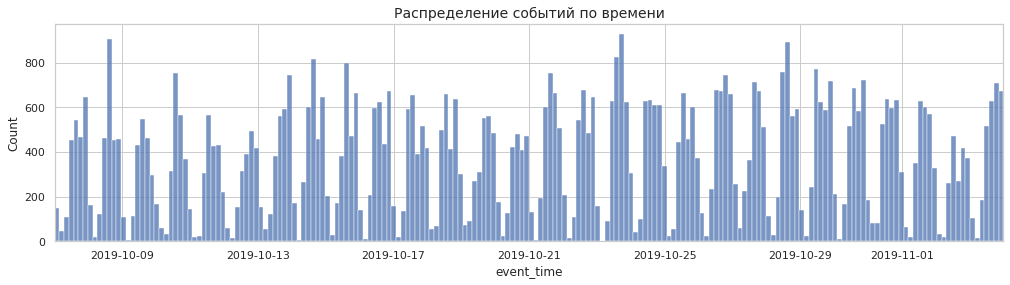

In [19]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(17, 4))

sns.histplot(mobile_dataset['event_time'],
             bins=200
             )
plt.xlim(mobile_dataset.event_time.min(), mobile_dataset.event_time.max())
plt.title('Распределение событий по времени', fontsize=14);



События распределены по времени достаточно равномерно, каких-то "каникул" не наблюдается. Видим, что каждые сутки в ночное время происходит спад пользовательской активности.

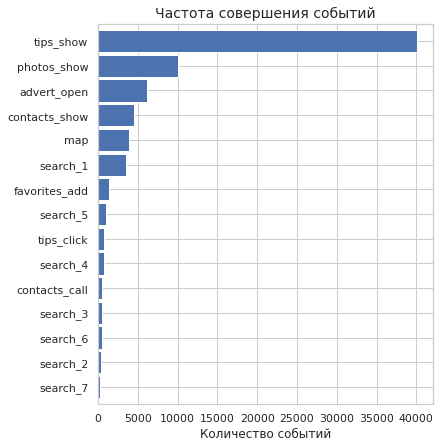

In [20]:
# Посмотрим на частоту совершения каждого из событий 
mobile_dataset.event.value_counts().sort_values(ascending=True).plot(kind='barh',
                                                                     figsize=(6, 7),
                                                                     width=0.9
                                                                     )
plt.xlabel('Количество событий')
plt.title('Частота совершения событий', fontsize=14);


Чаще всего пользователи пользуются подсказками и смотрят фотографии в объявлении. Реже всего совершают разные события, связанные с поиском по сайту. Однако, если события, связанные с поиском, объединить в одно, выводы могут поменяться

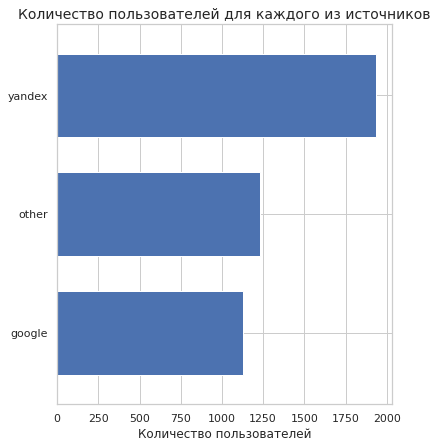

In [21]:
# Посмотрим из каких источников приходят пользователи
mobile_dataset.drop_duplicates(subset='user_id').source.value_counts().sort_values(ascending=True).plot(kind='barh',
                                                                                                        figsize=(
                                                                                                            6, 7),
                                                                                                        width=0.7
                                                                                                        )
plt.xlabel('Количество пользователей')
plt.title('Количество пользователей для каждого из источников', fontsize=14);


Больше всего пользователей пришло через Яндекс. Через Гугл и другие источники примерно одинаковое количество

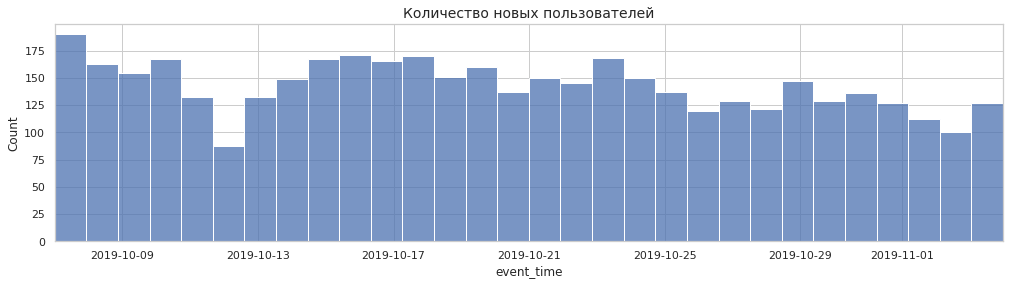

In [22]:
# Посмотрим в какие дни происходили первые действия пользователей
min_date = mobile_dataset.groupby('user_id').event_time.min()

plt.figure(figsize=(17, 4))

sns.histplot(min_date, bins=30)
plt.xlim(mobile_dataset.event_time.min(), mobile_dataset.event_time.max())
plt.title('Количество новых пользователей', fontsize=14);


Видим что на протяжении всего месяца какие-то пользователи совершали свою первую активность в приложении

### Ретеншн и конверсия

In [23]:
min_date

user_id
0001b1d5-b74a-4cbf-aeb0-7df5947bf349   2019-10-07 13:39:45.989359
00157779-810c-4498-9e05-a1e9e3cedf93   2019-10-19 21:34:33.849769
00463033-5717-4bf1-91b4-09183923b9df   2019-11-01 13:54:35.385028
004690c3-5a84-4bb7-a8af-e0c8f8fca64e   2019-10-18 22:14:05.555052
00551e79-152e-4441-9cf7-565d7eb04090   2019-10-25 16:44:41.263364
                                                  ...            
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07   2019-10-13 16:11:27.414960
ffc01466-fdb1-4460-ae94-e800f52eb136   2019-10-07 20:32:49.997044
ffcf50d9-293c-4254-8243-4890b030b238   2019-10-23 11:51:35.199237
ffe68f10-e48e-470e-be9b-eeb93128ff1a   2019-10-21 16:39:33.867145
fffb9e79-b927-4dbb-9b48-7fd09b23a62b   2019-10-12 00:57:21.241896
Name: event_time, Length: 4293, dtype: datetime64[ns]

In [24]:
# Зададим функцию, которая будет считать retention а заодно и датафрейм с пользовательскими сессиями

def get_retention(
    dataset,
    observation_date,
    horizon,
    ignore_horizon=False,
    dimensions=[]
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon - 1
        )

   # Создадим столбец с временем первой активности пользователей в приложении
    min_date = dataset.groupby('user_id').event_time.min()
    min_date.name = 'first_ts'
    dataset = dataset.merge(min_date, on='user_id')

    # Создадим столбец с временем начала сессии
    start_date = dataset.groupby('session_id').event_time.min()
    start_date.name = 'session_start'
    dataset = dataset.merge(start_date, on='session_id')

    # Создадим столбец с временем окончания сессии
    finish_date = dataset.groupby('session_id').event_time.max()
    finish_date.name = 'session_finish'
    dataset = dataset.merge(finish_date, on='session_id')

    # Создадим столбец с количеством действий внутри сессии
    av_events_num = dataset.groupby(
        ['session_id']).event_time.count()
    av_events_num.name = 'av_events_num'
    dataset = dataset.merge(av_events_num, on='session_id')

    sessions = dataset.drop_duplicates(subset='session_id')
    # mobile_dataset.event_time = pd.to_datetime(mobile_dataset.event_time)
    sessions['dt'] = pd.to_datetime(sessions.first_ts.dt.date)
    result_raw = sessions.query('dt <= @last_suitable_acquisition_date')
    sessions.drop(columns=['event', 'event_time'], inplace=True)

    result_raw['week'] = result_raw['dt'].dt.strftime('%U')

    # лайфтайм для каждой сессии
    # result_raw['lifetime'] = (
    #     result_raw['session_start'] - result_raw['first_ts']
    # ).dt.days
    result_raw['lifetime'] = result_raw['session_start'].dt.strftime('%U').astype(
        'int') - result_raw['first_ts'].dt.strftime('%U').astype('int')
    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    )
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped, sessions


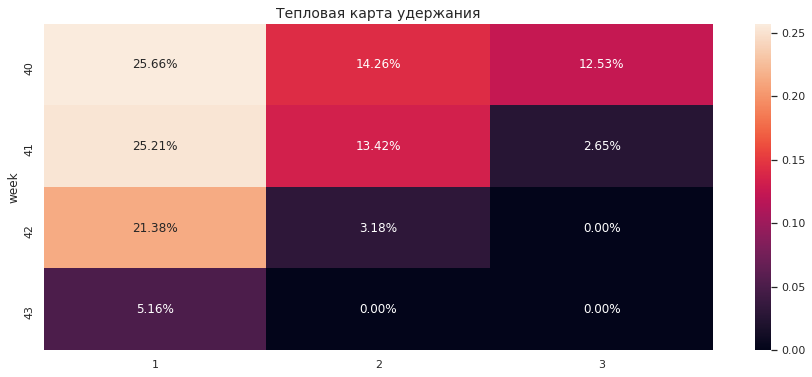

In [25]:
# Считаем ретеншн на момент последней даты с горизонтом анализа 4 недели, формируем когорты по неделям первой активности пользователей
retention_raw, retention, sessions = get_retention(
    mobile_dataset, observation_date=datetime(2019, 11, 3).date(), horizon=4, dimensions=['week']
)

# строим хитмэп без нулевого лайфтайма

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]).fillna(0),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания', fontsize=14)  # название графика
plt.show()


 Видим, что на первую неделю удержание пользователей составляет порядка 21-25%. Ко второй неделе удержание уже падает до 13-14%. К третьей неделе можем оценивать только по когорте 40 - для нее удержание упало с 14 до 12%

In [26]:
# Оценим конверсию в целевое действие contacts_show. 

round((mobile_dataset.query('event == "contacts_show"')['user_id'].nunique() / mobile_dataset['user_id'].nunique()) * 100,2)


22.85

Только 23% пользователей совершают целевое действие contacts_show

### Посчитаем следующие параметры-признаки для каждого из пользователей: 
- Средняя длина сессии 
- Количество проведенных сессий 
- Среднее число событий внутри сессии 
- Средний перерыв между сессиями

In [27]:
# посчитаем вспомогательные параметры

# длина каждой сессии
sessions['session_length'] = (
    sessions['session_finish'] - sessions['session_start']).astype('timedelta64[s]')

# окончание предыдущей сессии
sessions['prev_ses_end'] = sessions.groupby(
    'user_id')['session_finish'].shift(1)

# перерыв после предыдущей сессии
sessions['betw_ses_brake'] = (
    sessions.session_start - sessions.prev_ses_end).astype('timedelta64[s]')


In [28]:
# создадим датафрейм с параметрами пользователей

user_features = sessions.groupby('user_id').agg({'session_length': ['mean', 'count'], # средняя длина и количество сессий 
                                                 'av_events_num': 'mean', # среднее число событий внутри сессии
                                                 'betw_ses_brake': 'mean'}) # средний перерыв между сессиями
user_features.columns = ['mean_ses_len',
                         'ses_count',
                         'av_events_per_ses',
                         'av_brake']

user_features.fillna(0, inplace=True)
user_features.head(10)


,mean_ses_len,ses_count,av_events_per_ses,av_brake
user_id,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,689.750000,4,8.750000,428501.333333
00157779-810c-4498-9e05-a1e9e3cedf93,1961.833333,6,11.833333,253695.800000
00463033-5717-4bf1-91b4-09183923b9df,1482.000000,1,10.000000,0.000000
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1107.000000,6,5.333333,222928.600000
00551e79-152e-4441-9cf7-565d7eb04090,186.333333,3,2.666667,146495.500000
00554293-7e00-4122-b898-4e892c4a7c53,211.000000,2,5.500000,4854.000000
005fbea5-2678-406f-88a6-fbe9787e2268,648.000000,1,5.000000,0.000000
00653802-5ff1-4071-bc17-347fc4cef569,510.000000,1,5.000000,0.000000
006a32d4-ee10-40dc-b237-11e0fde81cbc,941.000000,1,6.000000,0.000000


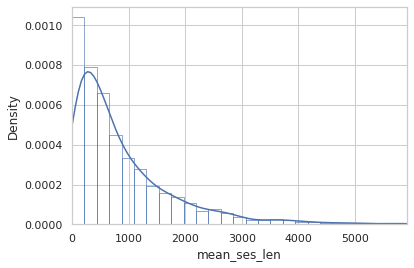

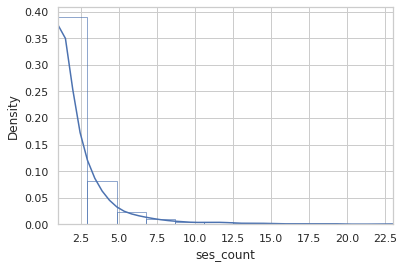

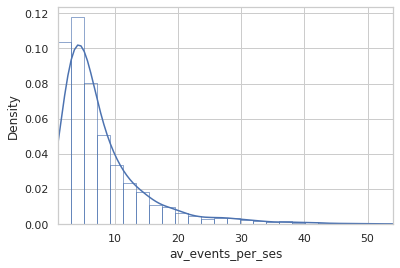

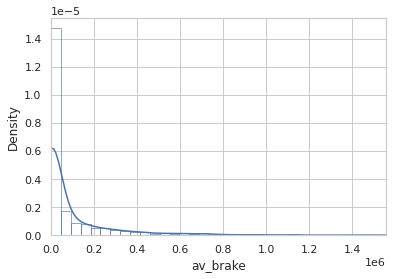

In [29]:
# посмотрим на распределения полученных признаков
for col in user_features.columns:
    sns.histplot(data=user_features,
                 x=col,
                 kde=True,
                 bins=50,
                 stat="density",
                 fill=False,
                 common_norm=False
                 )
    plt.xlim(user_features[col].min(),user_features[col].quantile(0.995))
    plt.show()


**Общий вывод:** 
- События распределены по времени достаточно равномерно, каких-то "каникул" не наблюдается. Видим, что каждые сутки в ночное время происходит спад пользовательской активности.
- Чаще всего пользователи пользуются подсказками и смотрят фотографии в объявлении. Реже всего совершают разные события, связанные с поиском по сайту. 
- Больше всего пользователей пришло через Яндекс. Через Гугл и другие источники примерно одинаковое количество
- Только 23% пользователей совершают целевое действие contacts_show
- На первую неделю удержание пользователей составляет порядка 21-25%. Ко второй неделе удержание уже падает до 13-14%.

## Сегментация пользователей

Сегментацию будем проводить на основе расчитанных параметров-признаков. Для начала оценим примерное количество кластеров, на которые делятся пользователи приложения, построим дендрограмму. Затем воспользуемся алгоритмом кластеризации K-means и разделим общий набор пользователей на нужное число кластеров

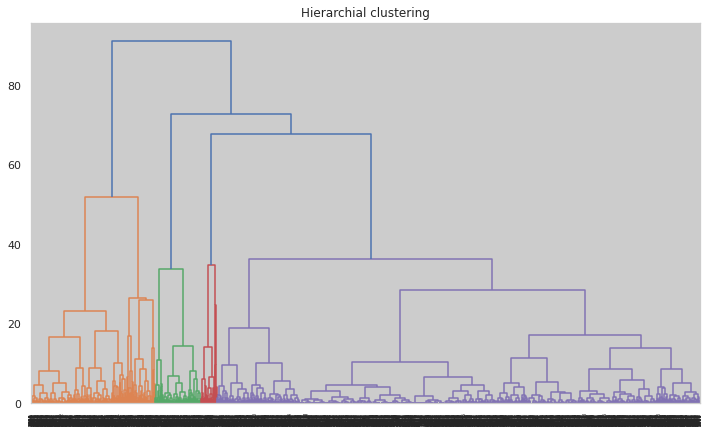

CPU times: user 1min 45s, sys: 22.3 s, total: 2min 7s
Wall time: 2min 8s


In [30]:
%%time
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(user_features)


# построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(12, 7))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()


На полученной дендрограмме иерархической кластеризации, в зависимости от порога расстояния, можно выделить примерно 3 - 4 кластера объектов. Для получения наиболее сбалансированных сегментов, положим количество кластеров равное 3

In [31]:
# обучим модель кластеризации K-Means и спрогнозируем кластеры пользователей.

km = KMeans(n_clusters=3, random_state=42)
user_features['segment'] = km.fit_predict(X_sc)
mobile_dataset = mobile_dataset.merge(user_features.segment, on='user_id')

In [32]:
# посмотрим сколько пользователей попало в каждый сегмент
user_features.segment.value_counts()


2    3151
0     641
1     501
Name: segment, dtype: int64

Видим, что полученные сегменты несколько несбалансированны. Это нормально, ведь для разного уровня активности и типа поведения количество пользователей может различаться

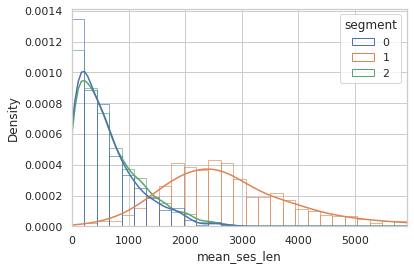

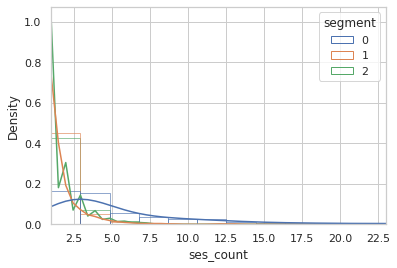

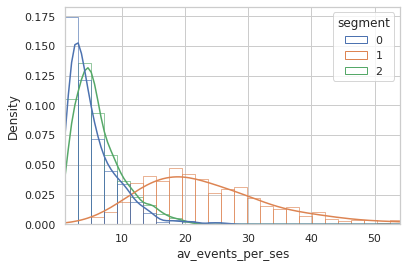

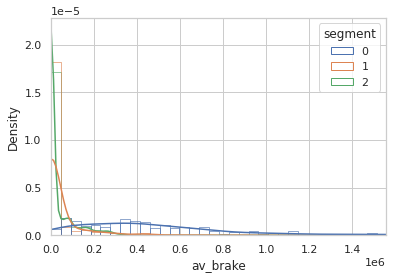

In [33]:
# посмотрим на распределения параметров-признаков для полученных сегементов пользователей

palette ={0: "C0", 1: "C1", 2: "C2", 3: "C3"}

for col in user_features.drop(columns='segment').columns:
    sns.histplot(data=user_features,
                 x=col,
                 hue='segment',
                 kde=True,
                 bins=50,
                 stat="density",
                 fill=False,
                 palette=palette,
                 common_norm=False
                 )
    plt.xlim(user_features[col].min(),user_features[col].quantile(0.995))

    plt.show()


По распределениям признакаков видим для полученных сегментов: 
- сегмент "1" характеризуется повышенной длительностью сессии и средним числом событий в сессии 
- сегмент "0" характеризуется повышенным количеством сессий и повышенными промежутками между сессий
- сегмент "2" характеризуется пониженными значениями всех признаков

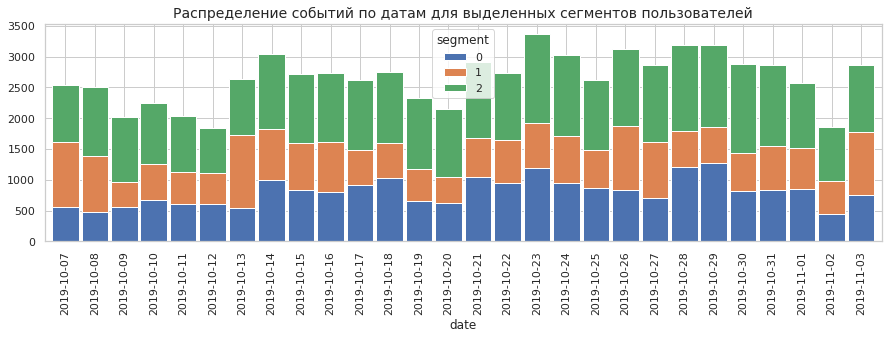

In [34]:
# Посмотрим на активность пользователей для полученных сегментов

mobile_dataset.pivot_table(index='date',
                           columns='segment',
                           values='user_id',
                           aggfunc='count').plot(kind='bar',
                                                 stacked=True,
                                                 width=0.9,
                                                 figsize=(15, 4)
                                                 )

plt.title('Распределение событий по датам для выделенных сегментов пользователей', fontsize=14);


Важно отметить, что пользователи каждого из сегментов активны в течении всего временного интервала

In [35]:
# Оценим конверсию в целевое действие contacts_show для полученных сегментов пользователей
for segment in user_features.segment.unique():
    conv = mobile_dataset.query('event == "contacts_show" and segment == @segment')[
        'user_id'].nunique()/mobile_dataset.query('segment == @segment')['user_id'].nunique()
    print(f'Конверсия для сегмента {segment}: {round(conv*100)}%'

          )


Конверсия для сегмента 0: 32%
Конверсия для сегмента 2: 20%
Конверсия для сегмента 1: 26%


- Видим, что сегмент "0" лидер по конверсии в contacts_show (повышенной длительностью сессии и средним числом событий в сессии ) - его конверсия составляет 33%, это самый активный сегмент
- Наименее активный сегмент - сегмент "2", его конверсия составляет 20%

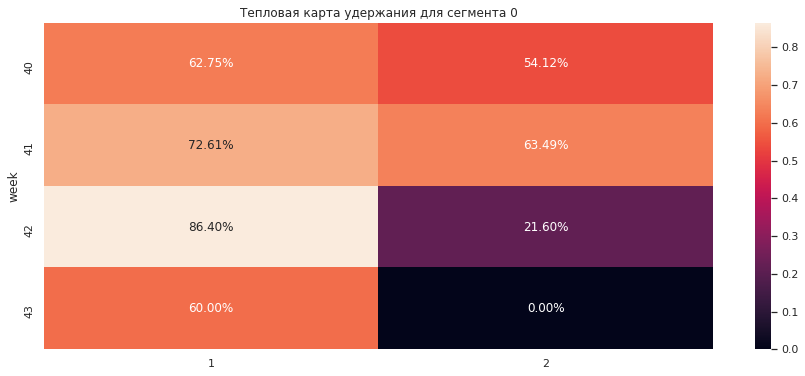

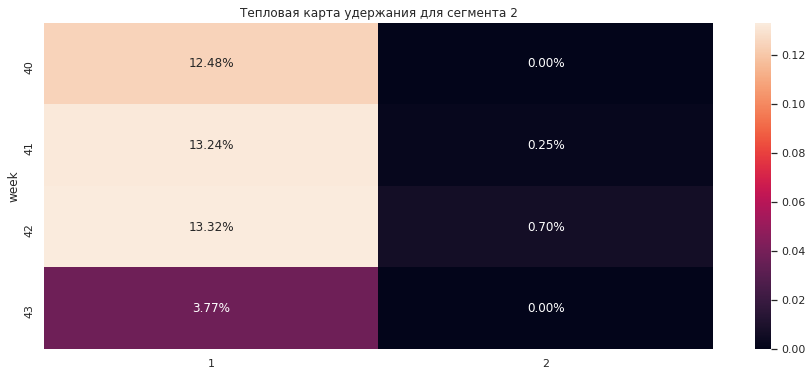

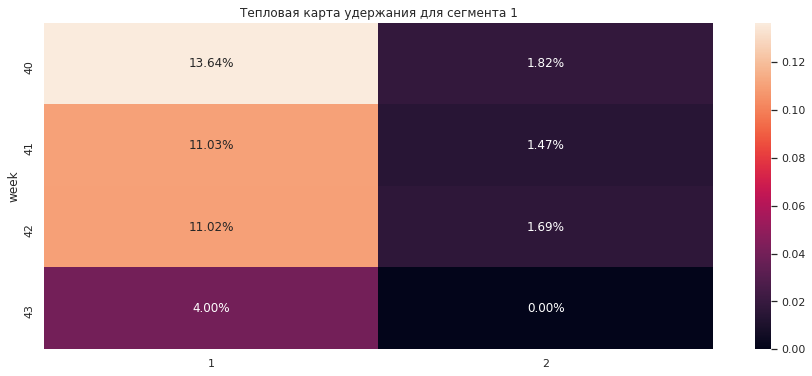

In [36]:
# Считаем ретеншн на момент последней даты с горизонтом анализа 3 недели, формируем когорты по неделям первой активности пользователей
for segment in user_features.segment.unique():
    retention_raw, retention, sessions = get_retention(
        mobile_dataset.query('segment == @segment'), observation_date=datetime(2019, 11, 3).date(), horizon=3, dimensions=['week']
    )
    # строим хитмэп без нулевого лайфтайма

    plt.figure(figsize=(15, 6))  # задаём размер графика
    sns.heatmap(
        retention.drop(columns=['cohort_size', 0]).fillna(0),  # удаляем лишние столбцы
        annot=True,  # включаем подписи
        fmt='.2%',  # переводим значения в проценты
    )
    # название графика
    plt.title(f'Тепловая карта удержания для сегмента {segment}')
    plt.show()


- С ретеншн наблюдается аналогичная ситуация как с конверсией для сегмента "0" - он снова лидирует. У него удержание на первую неделю 60-86%, в зависимости от когорты.
- Пользователи других двух сегментов удерживаются одинаково плохо - для них ретеншн на первую неделю находится на уровне 11-13%


**Таким образом, на данном этапе уже можем дать ответы на основные вопросы бизнеса:**

- Пользователи группы группы "0" склонны часто возвращаться в мобильное приложение (retention 60-86% на первую неделю, 54-63% на вторую)
- Пользователи группы группы "0" часто наиболее часто делают целевое действие (конверсия в contacts_show составляет 32%)


## Проверка статистических гипотез
На данном шаге проверим следующие статистические гипотезы:

1. Конверсии в просмотры контактов для пользователей, пришедших через Гугл и через Яндекс различаются
2. Конверсии в просмотры фотографии для лучшей и худшей группы (основываясь на ретеншн и конверсии) различаются

In [37]:
# зададим критический уровень статистической значимости
alpha = 0.05

### 1. Конверсии в просмотры контактов для пользователей, пришедших через Гугл и через Яндекс различаются
Сформулируем нулевую и альтернативную гипотезы:
- H0: Конверсиия в просмотры контактов для пользователей, пришедших через Гугл и через Яндекс одинакова
- H1: Конверсиия в просмотры контактов для пользователей, пришедших через Гугл и через Яндекс различается

In [38]:
# будем использовать z-тест для сформулированной гипотезы

event = np.array([mobile_dataset.query('event == "contacts_show" & source == "google"').user_id.nunique(), 
                     mobile_dataset.query('event == "contacts_show" & source == "yandex"').user_id.nunique()])

all_events = np.array([mobile_dataset.query('source == "google"').user_id.nunique(),
                     mobile_dataset.query('source == "yandex"').user_id.nunique() ])

# пропорция в первой группе:
p1 = event[0]/all_events[0]

# пропорция во второй группе:
p2 = event[1]/all_events[1]

# пропорция в комбинированном датасете:
p_combined = (event[0] + event[1]) / (all_events[0] + all_events[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / np.sqrt(
       p_combined * (1 - p_combined) * (1 / all_events[0] + 1 / all_events[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('Результаты статистического теста для групп {}, {}, и события {}:'.format("google","yandex", "contacts_show"))
print('p-значение: ', p_value)

if p_value < alpha:
       print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница\n')
else:
       print(
       'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными\n'
       ) 


Результаты статистического теста для групп google, yandex, и события contacts_show:
p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными



**Вывод:**  Различия между значениями конверсии в просмотр контакты для пользователей, пришедших через google и yandex в конкретном случае **не являются** статистически значимыми. 

### 2. Конверсии в просмотры фотографии для лучшей и худшей группы (основываясь на ретеншн и конверсии для выделенных сегментов) различаются
**Напомним, что сегмент (группа) с наилучшим ретеншн: #0; с наихудшим: #2**

Сформулируем нулевую и альтернативную гипотезы:
- H0: Конверсиия в просмотры фотографии для групп 0 и 2 одинакова

- H1: Конверсиия в просмотры фотографии для групп 0 и 2 различается

In [39]:
# будем использовать z-тест для сформулированной гипотезы

event = np.array([mobile_dataset.query('event == "photos_show" & segment == 0').user_id.nunique(), 
                     mobile_dataset.query('event == "photos_show" & segment == 2').user_id.nunique()])

all_events = np.array([mobile_dataset.query('segment == 0').user_id.nunique(),
                     mobile_dataset.query('segment == 2').user_id.nunique() ])

# пропорция в первой группе:
p1 = event[0]/all_events[0]

# пропорция во второй группе:
p2 = event[1]/all_events[1]

# пропорция в комбинированном датасете:
p_combined = (event[0] + event[1]) / (all_events[0] + all_events[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / np.sqrt(
       p_combined * (1 - p_combined) * (1 / all_events[0] + 1 / all_events[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('Результаты статистического теста для сегментов {}, {}, и события {}:'.format(0,2, "photos_show"))
print('p-значение: ', p_value)

if p_value < alpha:
       print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница\n')
else:
       print(
       'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными\n'
       ) 


Результаты статистического теста для сегментов 0, 2, и события photos_show:
p-значение:  9.51202876464663e-08
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница



 **Вывод:** Различия между значениями конверсии в просмотр фотографии для пользователей из сегментов #0 (с лучшим удержание и конверсией) и #2 (c худжшим удержанием и конверсией) в конкретном случае **являются** статистически значимыми. 

**Основные результаты по проверке статистических гипотез:**

- Различия между значениями конверсии в просмотр контакты для пользователей, пришедших через google и yandex в конкретном случае **не являются** статистически значимыми. 
- Различия между значениями конверсии в просмотр фотографии для пользователей из сегментов #0 (с лучшим удержанием и конверсией) и #2 (c худшим удержанием и конверсией) в конкретном случае **являются** статистически значимыми. 



## Заключение и выводы

- В рамках проекта был проанализирован набор данных с событиями, совершенных в мобильном приложении

- С помощью модели кластеризации K-means была произведена сегментация пользователей на четыре группы 

- Для выполнения сегментации были расчитаны следующие параметры-признаки активности пользователей: средняя длина сессии, количество проведенных сессий, среднее число событий внутри сессии, средний перерыв между сессиями

- Была определена группа (#0), пользователи которй склонны часто возвращаться в мобильное приложение (retention 60-86% на первую неделю, 54-63% на вторую)
- Была определена группа (#0), пользователи которй часто наиболее часто делают целевое действие (конверсия в contacts_show составляет 32%)
- Были проверены следующие статистические гипотезы: 
    1. Конверсии в просмотры контактов для пользователей, пришедших через Гугл и через Яндекс различаются. Различия между значениями конверсии в просмотр контакты для пользователей, пришедших через Гугл и Яндекс в конкретном случае **не являются** статистически значимыми. 
    
    2. Конверсии в просмотры фотографии для лучшей и худшей группы (основываясь на ретеншн для выделенных сегментов) различаются. Различия между значениями конверсии в просмотр фотографии для пользователей из сегментов #0 (с лучшим удержанием и конверсией) и #2 (c худшим удержанием и конверсией) в конкретном случае **являются** статистически значимыми. 
    
## Рекомендации
- Так как различия между значениями конверсии в просмотр фотографии  для лучшей и худшей групп является значимой, можно предположить, что то, как пользователи смотрят фотографии, может влиять на удержание пользователей в мобильном приложении. Таким образом, для улучшения удержания имеет смысл каким-то образом модифицировать функционал, связанный с просмотром фотографий в объявлениях. Самый простой вариант - попробовать для всех новых объявлений сделать обязательной загрузку фотографий 
- Так как конверсии в просмотры контактов для пользователей, пришедших через Гугл и через Яндекс не являются значимыми, можно допустить, что для бизнеса нет разницы через через Гугл и через Яндекс приходят пользователи


